<a href="https://colab.research.google.com/github/maryblack/dl_tinkoff/blob/master/dl_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_loader(train, batch_size):
    '''Cкачает мнист и сохранит где-то рядом.'''
    
    # Dataset в PyTorch -- это какой-то объект, который оборачивает сырые данные и делает с ними какой-нибудь препроцессинг
    dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
    
    # DataLoader делает из датасета генератор, который возвращает данные, сгруппированные по батчам
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader
    
train = get_loader(True, 64)
val = get_loader(False, 64)

0it [00:00, ?it/s]

9920512it [00:02, 3665093.96it/s]                             


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 57357.36it/s]                           
0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 842742.91it/s]                             
0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 21980.69it/s]            

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
model = nn.Sequential(
    nn.Linear(28*28, 100),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
)

In [0]:
def accuracy(model, val):
    total = 0
    correct = 0
    for X, y in val:
        X = X.view(-1, 784)
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    return correct / total

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.NLLLoss()

# Задание 1. Получить точность 0,98 (или хотя бы 0,97)

In [32]:
train_losses = []
for epoch in range(10):
    model.train()
    for X, y in train:
        X = X.view(-1, 784) 
        
        optimizer.zero_grad()
        
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        
        train_losses.append(loss.item())
        
        optimizer.step()
    model.eval() 
    print(f'accuracy epoch {epoch}: {accuracy(model, val)}')

accuracy epoch 0: 0.9589
accuracy epoch 1: 0.9615
accuracy epoch 2: 0.9609
accuracy epoch 3: 0.9632
accuracy epoch 4: 0.9674
accuracy epoch 5: 0.9653
accuracy epoch 6: 0.9644
accuracy epoch 7: 0.9656
accuracy epoch 8: 0.9703
accuracy epoch 9: 0.9658


accuracy epoch 8: 0.9703.

Теперь пробуем получить 0,98

In [0]:
model2 = nn.Sequential(
    nn.Linear(28*28, 400),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(400, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)# уменьшим learning rate
criterion = nn.NLLLoss()

In [72]:
train_losses = []
loss = 0
for epoch in range(10):
    model2.train()
    for X, y in train:
        X = X.view(-1, 784) 
        
        optimizer.zero_grad()
        
        output = model2(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
    model2.eval() 
    print(f'accuracy epoch {epoch}: {accuracy(model2, val)}')

accuracy epoch 0: 0.9587
accuracy epoch 1: 0.9694
accuracy epoch 2: 0.975
accuracy epoch 3: 0.9723
accuracy epoch 4: 0.9804
accuracy epoch 5: 0.9804
accuracy epoch 6: 0.9798
accuracy epoch 7: 0.982
accuracy epoch 8: 0.9793
accuracy epoch 9: 0.9798


accuracy epoch 7: 0.982

# Задание 2. Реализовать морфинг автоэнкодером (получите красивую гифку).

In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(400, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.LogSoftmax(dim=1)
            
        )
        
        self.decode = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

model = Autoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [137]:
for epoch in range(10):
    train_loss = 0
    for data, _ in train:

        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0472
epoch 1, loss 0.0301
epoch 2, loss 0.0256
epoch 3, loss 0.0230
epoch 4, loss 0.0215
epoch 5, loss 0.0206
epoch 6, loss 0.0200
epoch 7, loss 0.0195
epoch 8, loss 0.0191
epoch 9, loss 0.0186


In [0]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import numpy

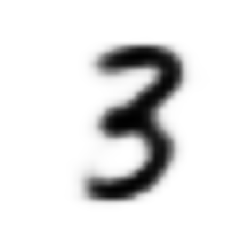

In [143]:
methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', \
           'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']

# в зависимости от метода получаются +/- красивые картинки (3, 6, 11)

def get(x):
    return train.dataset[x][0].view(1, 784)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True, interpolation=methods[8])

def morph(inputs, steps, delay):
    # перегоняем в латентное пространство все картинки на входе
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in numpy.linspace(0, 1, steps):
            # получаем проинтерполированную точку
            c = a*(1-t)+b*t
            # ...и декодируем её в изображение
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

morph(numpy.random.randint(0, len(train.dataset), 30), 20, 30)

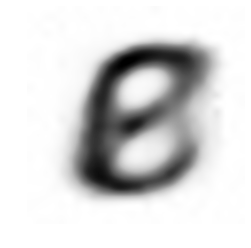

In [103]:
morph(numpy.random.randint(0, len(train.dataset), 30), 20, 30)